In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 100)

file_path_parkinson = "../../data/raw/ALZHEIMER_Dataset/dataset/parkinsons_disease_data.csv"
data_Parkinson = pd.read_csv(file_path_parkinson)
data_Parkinson.drop(columns=["DoctorInCharge", "EducationLevel", "PatientID"], inplace=True, errors="ignore")
print(data_Parkinson.info())
display(data_Parkinson.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105 entries, 0 to 2104
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       2105 non-null   int64  
 1   Gender                    2105 non-null   int64  
 2   Ethnicity                 2105 non-null   int64  
 3   BMI                       2105 non-null   float64
 4   Smoking                   2105 non-null   int64  
 5   AlcoholConsumption        2105 non-null   float64
 6   PhysicalActivity          2105 non-null   float64
 7   DietQuality               2105 non-null   float64
 8   SleepQuality              2105 non-null   float64
 9   FamilyHistoryParkinsons   2105 non-null   int64  
 10  TraumaticBrainInjury      2105 non-null   int64  
 11  Hypertension              2105 non-null   int64  
 12  Diabetes                  2105 non-null   int64  
 13  Depression                2105 non-null   int64  
 14  Stroke  

,Age,Gender,Ethnicity,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryParkinsons,TraumaticBrainInjury,Hypertension,Diabetes,Depression,Stroke,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,UPDRS,MoCA,FunctionalAssessment,Tremor,Rigidity,Bradykinesia,PosturalInstability,SpeechProblems,SleepDisorders,Constipation,Diagnosis
0,85,0,3,19.619878,0,5.108241,1.380660,3.893969,9.283194,0,0,0,0,0,0,129,60,222.842278,148.125623,37.867776,337.307114,6.458713,29.181289,1.572427,1,0,0,0,0,0,0,0
1,75,0,0,16.247339,1,6.027648,8.409804,8.513428,5.602470,0,0,0,0,0,0,163,76,210.501133,153.756463,77.228117,264.635521,37.306703,12.332639,4.787551,0,1,0,1,0,1,0,1
2,70,1,0,15.368239,0,2.242135,0.213275,6.498805,9.929824,0,0,0,1,0,0,113,93,287.387996,118.702600,85.588304,395.662649,67.838170,29.927783,2.130686,1,0,0,0,1,0,1,1
3,52,0,0,15.454557,0,5.997788,1.375045,6.715033,4.196189,0,0,0,0,0,0,146,78,280.339546,136.299186,51.869626,362.189688,52.964696,21.304268,3.391288,1,1,1,0,0,0,1,1
4,87,0,0,18.616042,0,9.775243,1.188607,4.657572,9.363925,0,0,0,0,0,0,115,94,284.014151,108.449452,25.069418,149.956586,21.804880,8.336364,3.200969,0,0,0,1,0,1,0,0


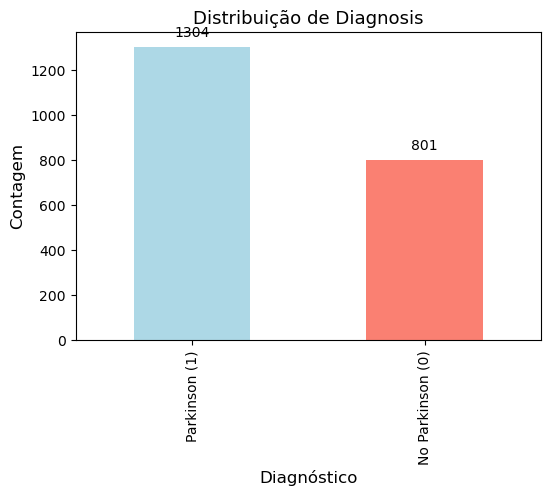

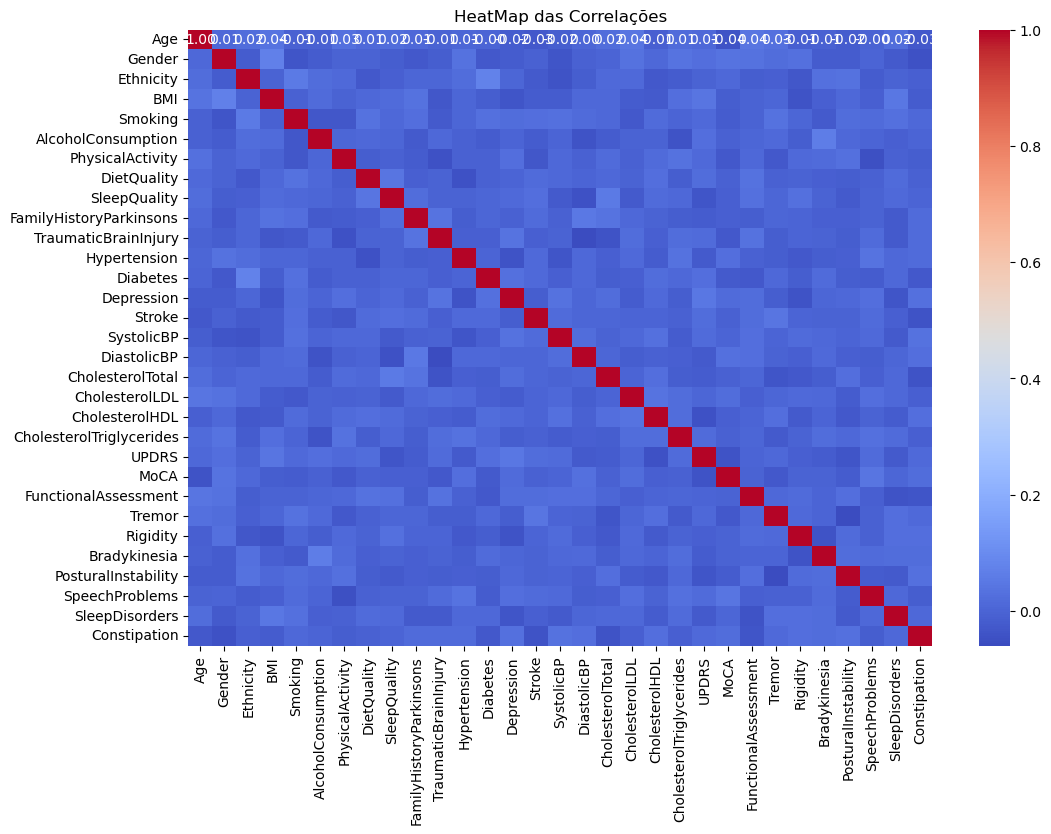

In [9]:
#Análise exploratória

diagnosis_counts = data_Parkinson["Diagnosis"].value_counts().rename({0: "No Parkinson (0)", 1: "Parkinson (1)"})
plt.figure(figsize=(6,4))
ax = diagnosis_counts.plot(kind="bar", color=["lightblue", "salmon"])
for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2.0, p.get_height()),
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                xytext=(0, 5),
                textcoords="offset points")
ax.set_title("Distribuição de Diagnosis", fontsize=13)
ax.set_xlabel("Diagnóstico", fontsize=12)
ax.set_ylabel("Contagem", fontsize=12)
plt.show()

df_numeric = data_Parkinson.select_dtypes(include=["number"]).copy()
if "Diagnosis" in df_numeric.columns:
    df_numeric.drop(columns=["Diagnosis"], inplace=True, errors="ignore")

plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("HeatMap das Correlações")
plt.show()

In [10]:
#Balanceamento das classes (Over e Under)

type_over_sampling = "resample"
if type_over_sampling == "smote":
    X = data_Parkinson.drop(columns=["Diagnosis"])
    y = data_Parkinson["Diagnosis"]
    sm = SMOTE(sampling_strategy="minority", random_state=42)
    X_over, y_over = sm.fit_resample(X, y)
    data_over_sampling = pd.concat([pd.DataFrame(X_over), pd.DataFrame(y_over, columns=["Diagnosis"])], axis=1)
else:
    data_majority = data_Parkinson[data_Parkinson["Diagnosis"] == 1].copy()
    data_minority = data_Parkinson[data_Parkinson["Diagnosis"] == 0].copy()
    data_minority_oversampled = resample(
        data_minority,
        replace=True,
        n_samples=len(data_majority) - len(data_minority),
        random_state=42
    )
    data_minority_oversampled = pd.concat([data_minority, data_minority_oversampled], ignore_index=True)
    data_over_sampling = pd.concat([data_majority, data_minority_oversampled], ignore_index=True)

data_majority_orig = data_Parkinson[data_Parkinson["Diagnosis"] == 1].copy()
data_minority_orig = data_Parkinson[data_Parkinson["Diagnosis"] == 0].copy()
data_minority_generated = data_over_sampling[data_over_sampling["Diagnosis"] == 0].iloc[len(data_minority_orig):].reset_index(drop=True)

majority_under_sampling = resample(
    data_majority_orig,
    replace=False,
    n_samples=int(len(data_majority_orig) - len(data_minority_generated) * 0.3),
    random_state=42
)
minority_generated_under_sampling = resample(
    data_minority_generated,
    replace=False,
    n_samples=int(len(data_minority_generated) - len(data_minority_generated) * 0.3),
    random_state=42
)
minority_under_sampling = pd.concat([data_minority_orig, minority_generated_under_sampling])
data_under_sampling = pd.concat([minority_under_sampling, majority_under_sampling])

print("Tamanho (Original):", data_Parkinson.shape)
print("Tamanho (Over):", data_over_sampling.shape)
print("Tamanho (Under):", data_under_sampling.shape)

Tamanho (Original): (2105, 32)
Tamanho (Over): (2608, 32)
Tamanho (Under): (2306, 32)


In [11]:
#Separar os dados em treino e teste (Original, Over, Under)

X_parkinson = data_Parkinson.drop(columns=["Diagnosis"])
y_parkinson = data_Parkinson["Diagnosis"]
X_over = data_over_sampling.drop(columns=["Diagnosis"])
y_over = data_over_sampling["Diagnosis"]
X_under = data_under_sampling.drop(columns=["Diagnosis"])
y_under = data_under_sampling["Diagnosis"]

X_train_parkinson, X_test_parkinson, y_train_parkinson, y_test_parkinson = train_test_split(
    X_parkinson, y_parkinson, test_size=0.2, random_state=42, shuffle=True
)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_over, y_over, test_size=0.2, random_state=42, shuffle=True
)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under, y_under, test_size=0.2, random_state=42, shuffle=True
)

In [12]:
#Função para avaliar os modelos 

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Modelo", do_prob=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== AVALIAÇÃO: {model_name.upper()} ===")
    print(classification_report(y_test, y_pred, digits=4))
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy de Teste: {acc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusão:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap="Blues", colorbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()
    if do_prob and hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc_val = auc(fpr, tpr)
        print(f"AUC: {roc_auc_val:.4f}")
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc_val:.3f})")
        plt.plot([0,1],[0,1],"r--")
        plt.xlim([0,1])
        plt.ylim([0,1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.show()
    return acc, model

In [13]:
#Definir os parâmetros do GridSearch e conjuntos de hiperparâmetros

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_gridsearch_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, model_name="Modelo"):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="accuracy",
        cv=skf,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    print(f"\nMelhores Parâmetros ({model_name}): {gs.best_params_}")
    best_model = gs.best_estimator_
    acc, trained_model = evaluate_model(best_model, X_train, y_train, X_test, y_test, model_name=model_name)
    return acc, trained_model, gs.best_params_

param_grid_knn = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"]
}
param_grid_logistic = {
    "C": [0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}
param_grid_svm = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}
param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2],
    "class_weight": ["balanced", "balanced_subsample"]
}
models_and_grids = [
    ("KNN", KNeighborsClassifier(), param_grid_knn),
    ("LogisticRegression", LogisticRegression(random_state=42), param_grid_logistic),
    ("SVM", SVC(probability=True, random_state=42), param_grid_svm),
    ("DecisionTree", DecisionTreeClassifier(random_state=42), param_grid_dt),
    ("RandomForest", RandomForestClassifier(random_state=42), param_grid_rf),
]


############### MODELOS NO DATASET: ORIGINAL ###############

--- Rodando GridSearch para: KNN ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (KNN): {'n_neighbors': 7, 'weights': 'uniform'}

=== AVALIAÇÃO: KNN ===
              precision    recall  f1-score   support

           0     0.6212    0.5467    0.5816       150
           1     0.7647    0.8155    0.7893       271

    accuracy                         0.7197       421
   macro avg     0.6930    0.6811    0.6854       421
weighted avg     0.7136    0.7197    0.7153       421

Acurácia de Teste: 0.7197
Matriz de Confusão:
[[ 82  68]
 [ 50 221]]


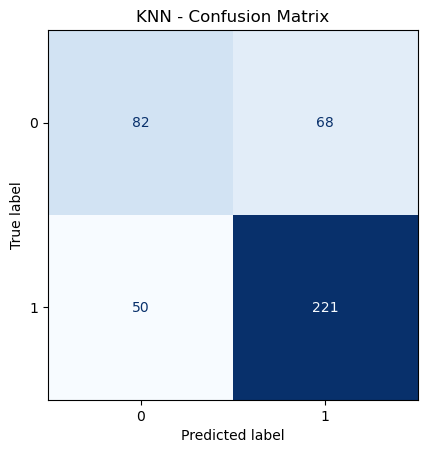

AUC: 0.7256


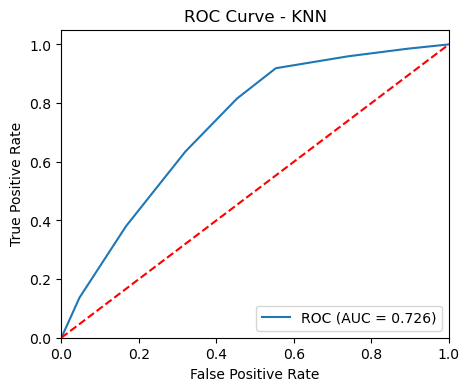

--- Rodando GridSearch para: LogisticRegression ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (LogisticRegression): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

=== AVALIAÇÃO: LOGISTICREGRESSION ===
              precision    recall  f1-score   support

           0     0.7000    0.6533    0.6759       150
           1     0.8149    0.8450    0.8297       271

    accuracy                         0.7767       421
   macro avg     0.7575    0.7492    0.7528       421
weighted avg     0.7740    0.7767    0.7749       421

Acurácia de Teste: 0.7767
Matriz de Confusão:
[[ 98  52]
 [ 42 229]]


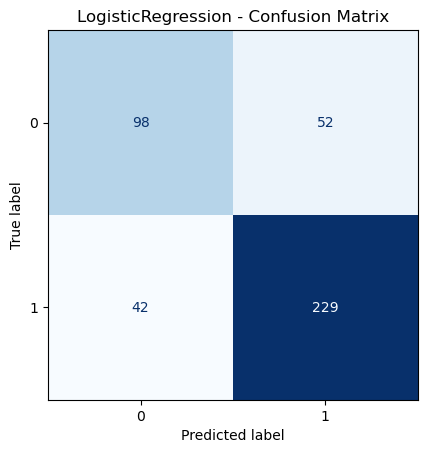

AUC: 0.8788


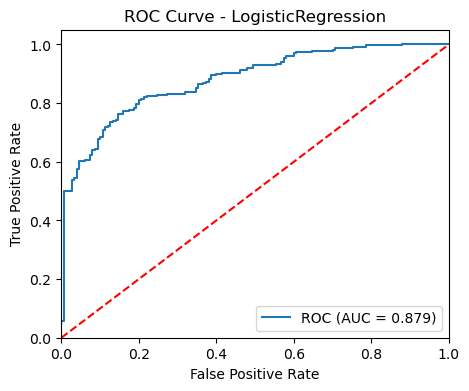

--- Rodando GridSearch para: SVM ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (SVM): {'C': 1, 'kernel': 'linear'}

=== AVALIAÇÃO: SVM ===
              precision    recall  f1-score   support

           0     0.7163    0.6733    0.6942       150
           1     0.8250    0.8524    0.8385       271

    accuracy                         0.7886       421
   macro avg     0.7707    0.7629    0.7663       421
weighted avg     0.7863    0.7886    0.7871       421

Acurácia de Teste: 0.7886
Matriz de Confusão:
[[101  49]
 [ 40 231]]


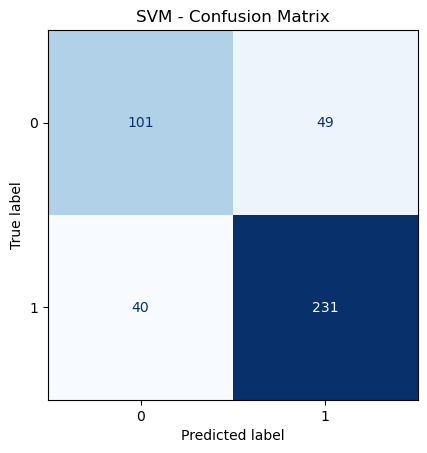

AUC: 0.8766


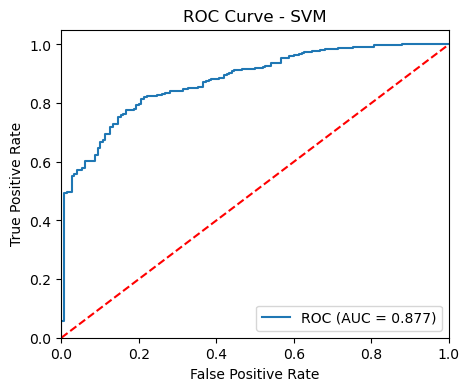

--- Rodando GridSearch para: DecisionTree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Melhores Parâmetros (DecisionTree): {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}

=== AVALIAÇÃO: DECISIONTREE ===
              precision    recall  f1-score   support

           0     0.8023    0.9200    0.8571       150
           1     0.9518    0.8745    0.9115       271

    accuracy                         0.8907       421
   macro avg     0.8771    0.8973    0.8843       421
weighted avg     0.8985    0.8907    0.8922       421

Acurácia de Teste: 0.8907
Matriz de Confusão:
[[138  12]
 [ 34 237]]


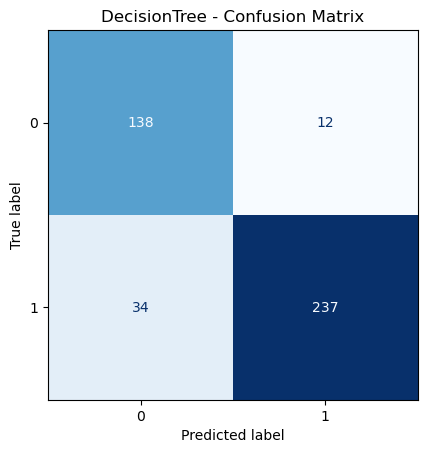

AUC: 0.9172


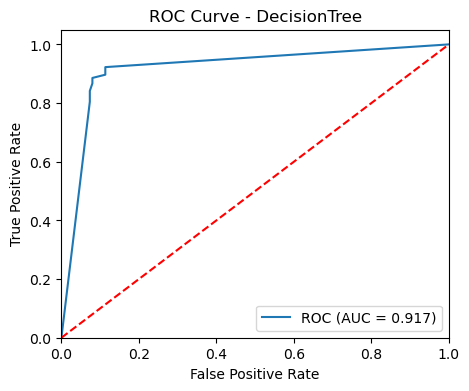

--- Rodando GridSearch para: RandomForest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Melhores Parâmetros (RandomForest): {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}

=== AVALIAÇÃO: RANDOMFOREST ===
              precision    recall  f1-score   support

           0     0.8428    0.8933    0.8673       150
           1     0.9389    0.9077    0.9231       271

    accuracy                         0.9026       421
   macro avg     0.8908    0.9005    0.8952       421
weighted avg     0.9047    0.9026    0.9032       421

Acurácia de Teste: 0.9026
Matriz de Confusão:
[[134  16]
 [ 25 246]]


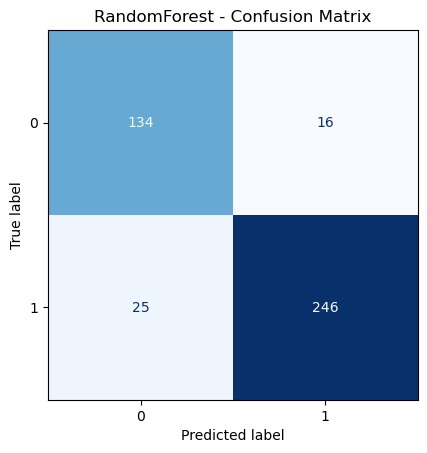

AUC: 0.9485


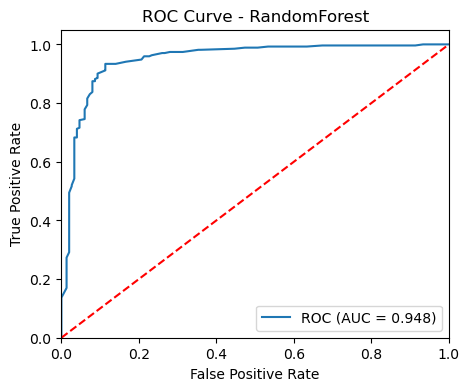


############### MODELOS NO DATASET: OVER-SAMPLING ###############

--- Rodando GridSearch para: KNN ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (KNN): {'n_neighbors': 7, 'weights': 'distance'}

=== AVALIAÇÃO: KNN ===
              precision    recall  f1-score   support

           0     0.7007    0.8224    0.7567       259
           1     0.7890    0.6540    0.7152       263

    accuracy                         0.7375       522
   macro avg     0.7448    0.7382    0.7359       522
weighted avg     0.7452    0.7375    0.7358       522

Acurácia de Teste: 0.7375
Matriz de Confusão:
[[213  46]
 [ 91 172]]


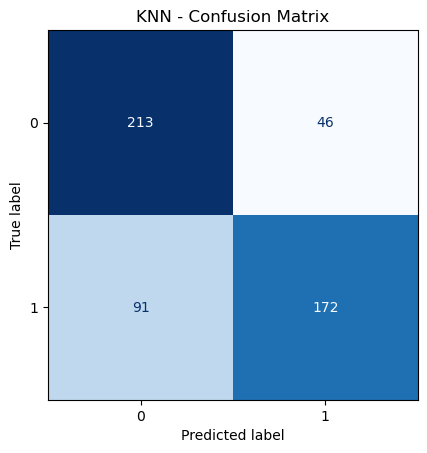

AUC: 0.8309


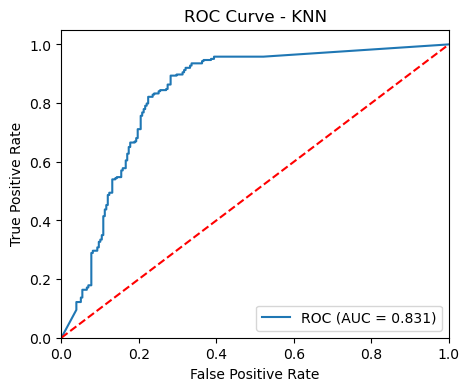

--- Rodando GridSearch para: LogisticRegression ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (LogisticRegression): {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

=== AVALIAÇÃO: LOGISTICREGRESSION ===
              precision    recall  f1-score   support

           0     0.7876    0.7876    0.7876       259
           1     0.7909    0.7909    0.7909       263

    accuracy                         0.7893       522
   macro avg     0.7893    0.7893    0.7893       522
weighted avg     0.7893    0.7893    0.7893       522

Acurácia de Teste: 0.7893
Matriz de Confusão:
[[204  55]
 [ 55 208]]


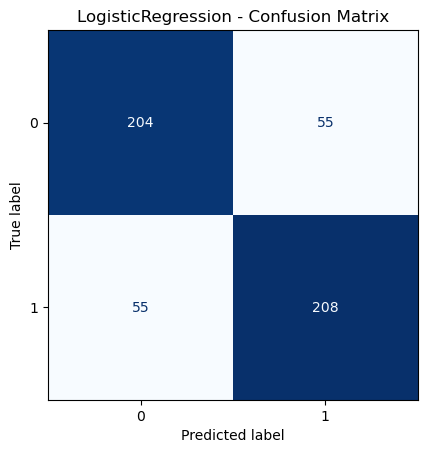

AUC: 0.8722


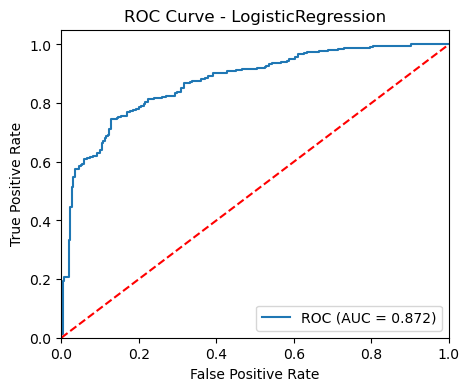

--- Rodando GridSearch para: SVM ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (SVM): {'C': 1, 'kernel': 'linear'}

=== AVALIAÇÃO: SVM ===
              precision    recall  f1-score   support

           0     0.7909    0.8031    0.7969       259
           1     0.8031    0.7909    0.7969       263

    accuracy                         0.7969       522
   macro avg     0.7970    0.7970    0.7969       522
weighted avg     0.7970    0.7969    0.7969       522

Acurácia de Teste: 0.7969
Matriz de Confusão:
[[208  51]
 [ 55 208]]


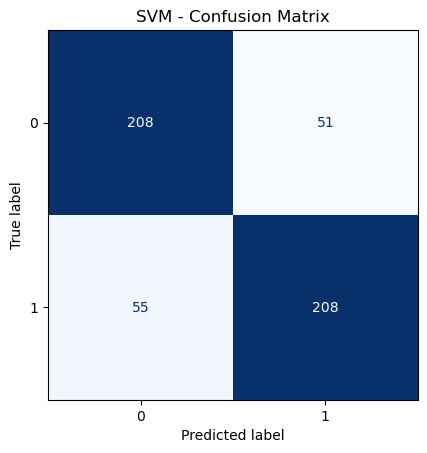

AUC: 0.8736


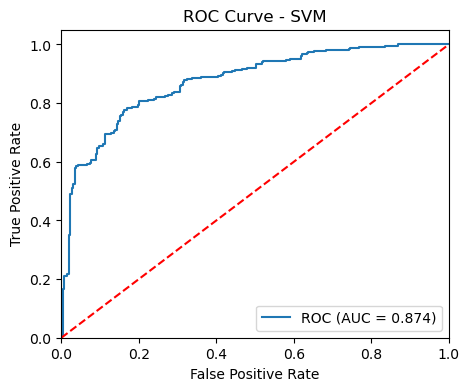

--- Rodando GridSearch para: DecisionTree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Melhores Parâmetros (DecisionTree): {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}

=== AVALIAÇÃO: DECISIONTREE ===
              precision    recall  f1-score   support

           0     0.9027    0.8958    0.8992       259
           1     0.8981    0.9049    0.9015       263

    accuracy                         0.9004       522
   macro avg     0.9004    0.9003    0.9004       522
weighted avg     0.9004    0.9004    0.9004       522

Acurácia de Teste: 0.9004
Matriz de Confusão:
[[232  27]
 [ 25 238]]


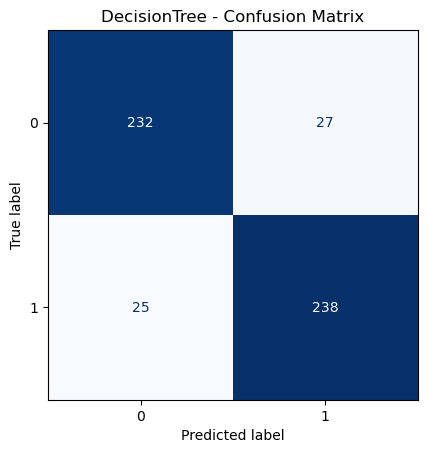

AUC: 0.9160


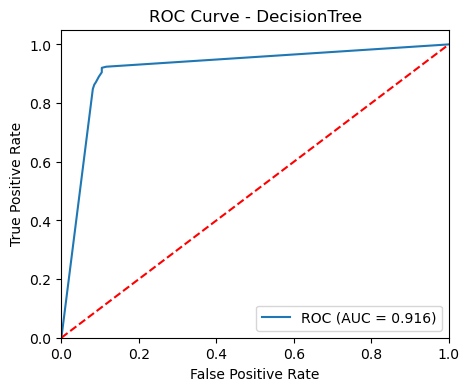

--- Rodando GridSearch para: RandomForest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Melhores Parâmetros (RandomForest): {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 100}

=== AVALIAÇÃO: RANDOMFOREST ===
              precision    recall  f1-score   support

           0     0.9209    0.8996    0.9102       259
           1     0.9033    0.9240    0.9135       263

    accuracy                         0.9119       522
   macro avg     0.9121    0.9118    0.9118       522
weighted avg     0.9121    0.9119    0.9119       522

Acurácia de Teste: 0.9119
Matriz de Confusão:
[[233  26]
 [ 20 243]]


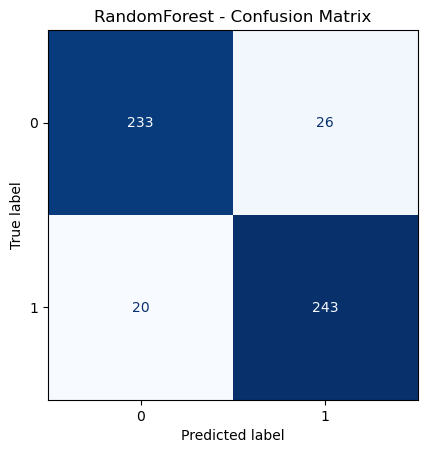

AUC: 0.9613


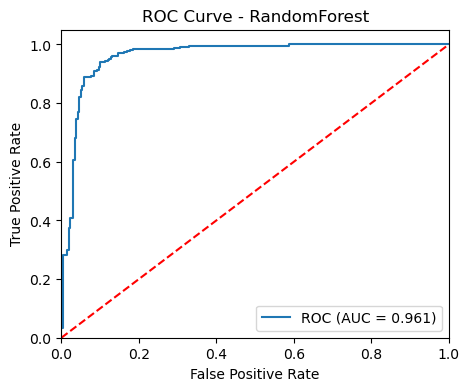


############### MODELOS NO DATASET: UNDER-SAMPLING ###############

--- Rodando GridSearch para: KNN ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (KNN): {'n_neighbors': 7, 'weights': 'distance'}

=== AVALIAÇÃO: KNN ===
              precision    recall  f1-score   support

           0     0.6969    0.7763    0.7344       228
           1     0.7548    0.6709    0.7104       234

    accuracy                         0.7229       462
   macro avg     0.7258    0.7236    0.7224       462
weighted avg     0.7262    0.7229    0.7223       462

Acurácia de Teste: 0.7229
Matriz de Confusão:
[[177  51]
 [ 77 157]]


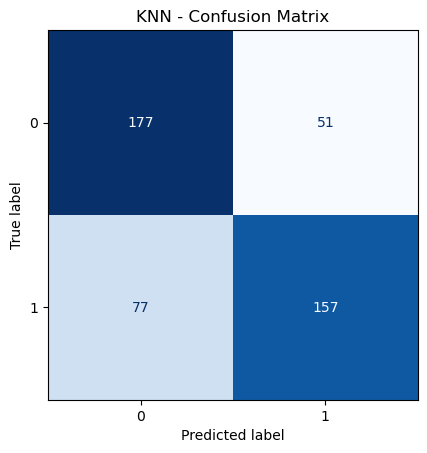

AUC: 0.8024


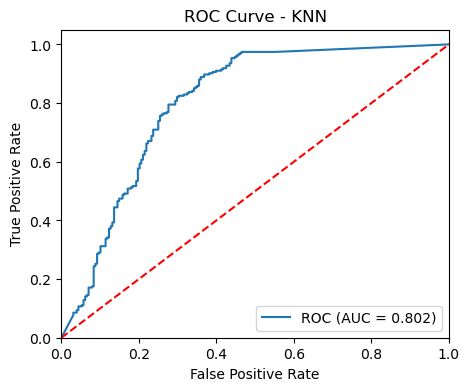

--- Rodando GridSearch para: LogisticRegression ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (LogisticRegression): {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

=== AVALIAÇÃO: LOGISTICREGRESSION ===
              precision    recall  f1-score   support

           0     0.7549    0.8377    0.7942       228
           1     0.8230    0.7350    0.7765       234

    accuracy                         0.7857       462
   macro avg     0.7890    0.7864    0.7854       462
weighted avg     0.7894    0.7857    0.7852       462

Acurácia de Teste: 0.7857
Matriz de Confusão:
[[191  37]
 [ 62 172]]


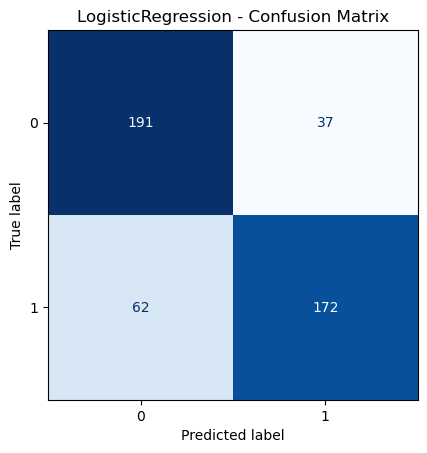

AUC: 0.8804


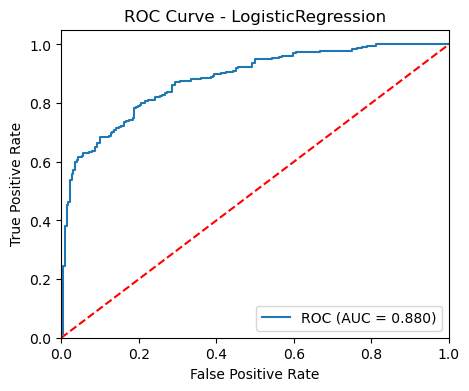

--- Rodando GridSearch para: SVM ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores Parâmetros (SVM): {'C': 1, 'kernel': 'linear'}

=== AVALIAÇÃO: SVM ===
              precision    recall  f1-score   support

           0     0.7490    0.8377    0.7909       228
           1     0.8213    0.7265    0.7710       234

    accuracy                         0.7814       462
   macro avg     0.7851    0.7821    0.7809       462
weighted avg     0.7856    0.7814    0.7808       462

Acurácia de Teste: 0.7814
Matriz de Confusão:
[[191  37]
 [ 64 170]]


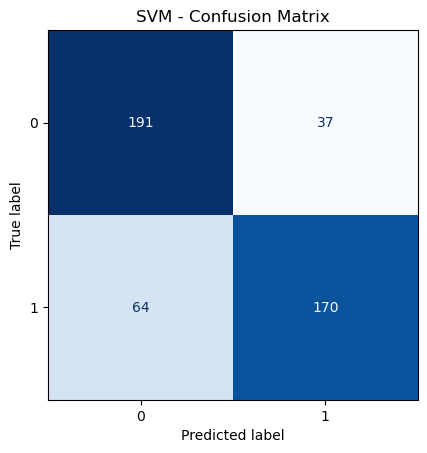

AUC: 0.8801


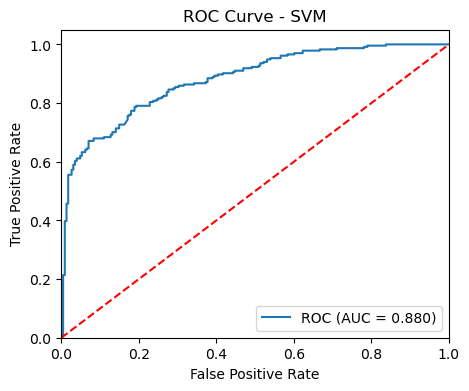

--- Rodando GridSearch para: DecisionTree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Melhores Parâmetros (DecisionTree): {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5}

=== AVALIAÇÃO: DECISIONTREE ===
              precision    recall  f1-score   support

           0     0.8452    0.9342    0.8875       228
           1     0.9286    0.8333    0.8784       234

    accuracy                         0.8831       462
   macro avg     0.8869    0.8838    0.8829       462
weighted avg     0.8874    0.8831    0.8829       462

Acurácia de Teste: 0.8831
Matriz de Confusão:
[[213  15]
 [ 39 195]]


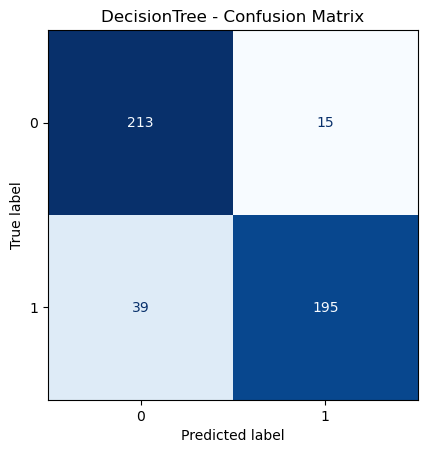

AUC: 0.8896


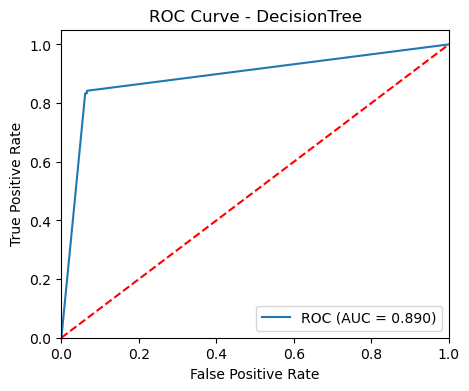

--- Rodando GridSearch para: RandomForest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Melhores Parâmetros (RandomForest): {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}

=== AVALIAÇÃO: RANDOMFOREST ===
              precision    recall  f1-score   support

           0     0.9149    0.9430    0.9287       228
           1     0.9427    0.9145    0.9284       234

    accuracy                         0.9286       462
   macro avg     0.9288    0.9288    0.9286       462
weighted avg     0.9290    0.9286    0.9286       462

Acurácia de Teste: 0.9286
Matriz de Confusão:
[[215  13]
 [ 20 214]]


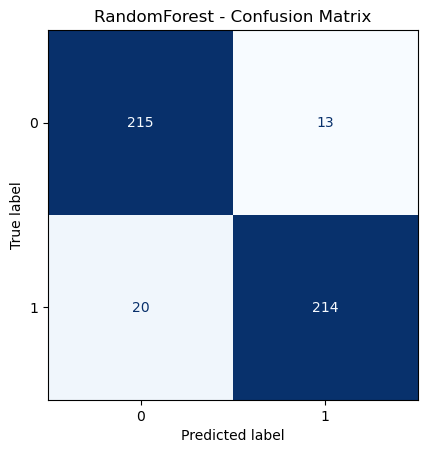

AUC: 0.9739


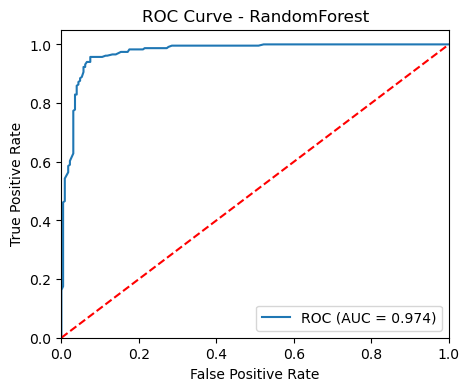

In [14]:
#Executar o GridSearch em cada conjunto (Original, Over e Under)

results_all = {
    "Original": {},
    "Over": {},
    "Under": {}
}

def run_all_models_on_dataset(models_and_grids, X_train, y_train, X_test, y_test, dataset_name="Original"):
    local_results = {}
    print(f"\n############### MODELOS NO DATASET: {dataset_name} ###############\n")
    for (model_name, model, param_grid) in models_and_grids:
        print(f"---GridSearch para: {model_name} ---")
        best_acc, best_model, best_params = run_gridsearch_and_evaluate(
            model, param_grid, X_train, y_train, X_test, y_test, model_name=model_name
        )
        local_results[model_name] = {
            "best_accuracy": best_acc,
            "best_params": best_params
        }
    return local_results

results_all["Original"] = run_all_models_on_dataset(
    models_and_grids, 
    X_train_parkinson, y_train_parkinson,
    X_test_parkinson, y_test_parkinson,
    dataset_name="ORIGINAL"
)

results_all["Over"] = run_all_models_on_dataset(
    models_and_grids, 
    X_train_over, y_train_over,
    X_test_over, y_test_over,
    dataset_name="OVER-SAMPLING"
)

results_all["Under"] = run_all_models_on_dataset(
    models_and_grids, 
    X_train_under, y_train_under,
    X_test_under, y_test_under,
    dataset_name="UNDER-SAMPLING"
)

In [15]:
print("\n\n=========== COMPARAÇÃO FINAL DOS RESULTADOS ===========\n")
for ds in ["Original", "Over", "Under"]:
    print(f"\n--- Dataset: {ds} ---")
    for model_name, info in results_all[ds].items():
        acc = info["best_accuracy"]
        params = info["best_params"]
        print(f"{model_name:<15} -> Accuracy: {acc:.4f} | Params: {params}")



=========== COMPARAÇÃO FINAL DOS RESULTADOS ===========


--- Dataset: Original ---
KNN             -> Accuracy: 0.7197 | Params: {'n_neighbors': 7, 'weights': 'uniform'}
LogisticRegression -> Accuracy: 0.7767 | Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
SVM             -> Accuracy: 0.7886 | Params: {'C': 1, 'kernel': 'linear'}
DecisionTree    -> Accuracy: 0.8907 | Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
RandomForest    -> Accuracy: 0.9026 | Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}

--- Dataset: Over ---
KNN             -> Accuracy: 0.7375 | Params: {'n_neighbors': 7, 'weights': 'distance'}
LogisticRegression -> Accuracy: 0.7893 | Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
SVM             -> Accuracy: 0.7969 | Params: {'C': 1, 'kernel': 'linear'}
DecisionTree    -> Accuracy: 0.9004 | Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
RandomFor

In [ ]:
#--- Dataset: Original ---
#KNN             -> Accuracy: 0.7197 | Params: {'n_neighbors': 7, 'weights': 'uniform'}
#LogisticRegression -> Accuracy: 0.7767 | Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
#SVM             -> Accuracy: 0.7886 | Params: {'C': 1, 'kernel': 'linear'}
#DecisionTree    -> Accuracy: 0.8907 | Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
#RandomForest    -> Accuracy: 0.9026 | Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}
#
#--- Dataset: Over ---
#KNN             -> Accuracy: 0.7375 | Params: {'n_neighbors': 7, 'weights': 'distance'}
#LogisticRegression -> Accuracy: 0.7893 | Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
#SVM             -> Accuracy: 0.7969 | Params: {'C': 1, 'kernel': 'linear'}
#DecisionTree    -> Accuracy: 0.9004 | Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
#RandomForest    -> Accuracy: 0.9119 | Params: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 100}
#
#--- Dataset: Under ---
#KNN             -> Accuracy: 0.7229 | Params: {'n_neighbors': 7, 'weights': 'distance'}
#LogisticRegression -> Accuracy: 0.7857 | Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
#SVM             -> Accuracy: 0.7814 | Params: {'C': 1, 'kernel': 'linear'}
#DecisionTree    -> Accuracy: 0.8831 | Params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5}
#RandomForest    -> Accuracy: 0.9286 | Params: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}